# Imports

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
import missingno as msno

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer

In [75]:
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [76]:
import warnings
warnings.simplefilter("ignore")

# Data preparation

## Info

In [6]:
df = pd.read_csv("data.csv", index_col="id", true_values=["Yes"], false_values=["No"])
df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,True,False,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,True,True,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,True,False,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,True,False,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,True,True,Messenger,Green,17.749338,86.02312


In [7]:
df.shape

(300000, 10)

In [8]:
target_col = "Price"

In [9]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 25.2+ MB


Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

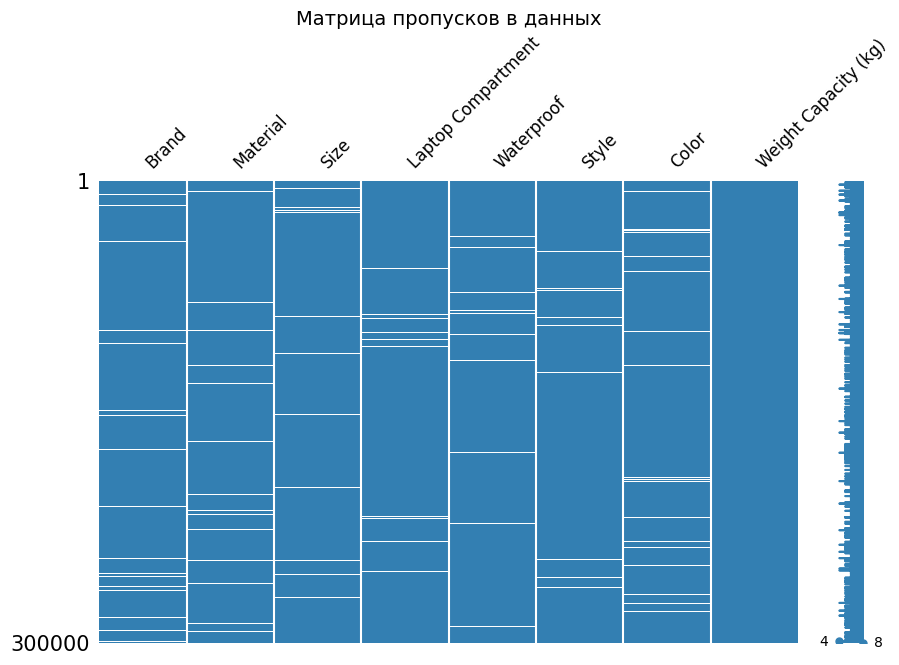

In [10]:
msno.matrix(df.drop(["Compartments", "Price"], axis=1), figsize=(10, 6), fontsize=12, color=(0.2, 0.5, 0.7))
plt.title('Матрица пропусков в данных', fontsize=14)
plt.show()

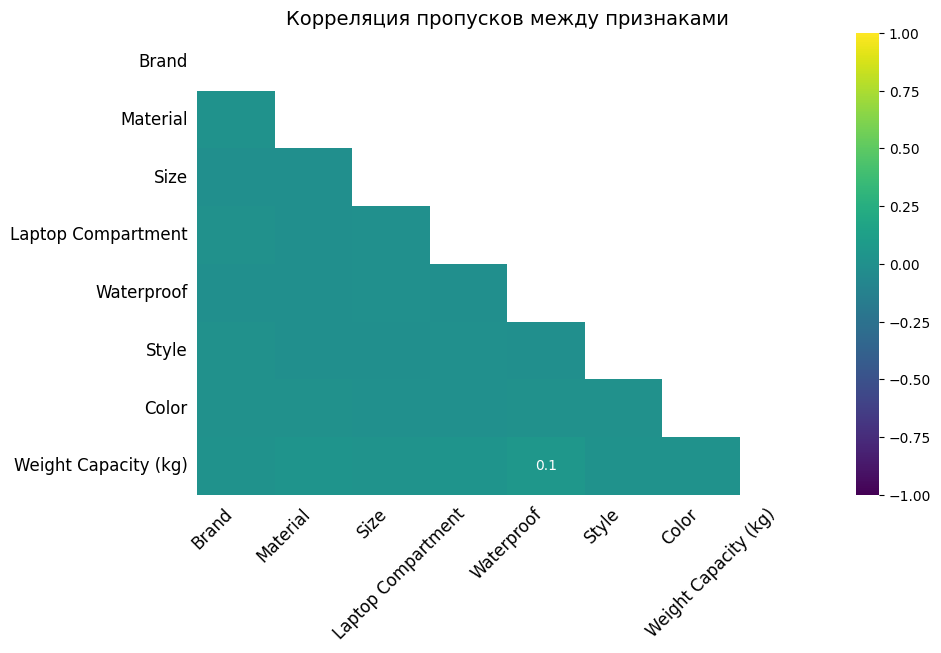

In [11]:
msno.heatmap(df, figsize=(10, 6), fontsize=12, cmap='viridis')
plt.title('Корреляция пропусков между признаками', fontsize=14)
plt.show()

In [12]:
print("Средняя цена с Brand:", df[df['Brand'].notna()]['Price'].mean())
print("Средняя цена без Brand:", df[df['Brand'].isna()]['Price'].mean())

Средняя цена с Brand: 81.42910495041251
Средняя цена без Brand: 80.87274884286451


In [13]:
# Проверка доли пропусков в Brand для разных материалов
for column in df.drop(["Brand", "Price"], axis=1).columns:
    print("ISNA:", df[df["Brand"].isna()][column].value_counts(normalize=True))
    print()
    print("NOTNA:", df[df["Brand"].notna()][column].value_counts(normalize=True))
    print()
    print("-" * 9)
    print()

ISNA: Material
Polyester    0.272844
Leather      0.251790
Nylon        0.241744
Canvas       0.233622
Name: proportion, dtype: float64

NOTNA: Material
Polyester    0.273036
Leather      0.251722
Nylon        0.242090
Canvas       0.233152
Name: proportion, dtype: float64

---------

ISNA: Size
Large     0.347686
Medium    0.341222
Small     0.311093
Name: proportion, dtype: float64

NOTNA: Size
Medium    0.347528
Large     0.335813
Small     0.316659
Name: proportion, dtype: float64

---------

ISNA: Compartments
9.0     0.104688
4.0     0.104276
7.0     0.102731
1.0     0.102421
2.0     0.100567
10.0    0.099845
3.0     0.099742
5.0     0.096033
8.0     0.095930
6.0     0.093766
Name: proportion, dtype: float64

NOTNA: Compartments
1.0     0.105320
4.0     0.105017
2.0     0.102031
3.0     0.101018
7.0     0.100453
5.0     0.099991
9.0     0.099723
10.0    0.099368
8.0     0.096378
6.0     0.090701
Name: proportion, dtype: float64

---------

ISNA: Laptop Compartment
True     0.5046

Дизбаланса классов практически. Если удалить строки с пропущенным Brand, мы потеряем лишь в Weight Capacity

## Fillna 

In [14]:
fill_brand_df = df.copy()

In [15]:
fill_brand_df[["Brand", "Material", "Size"]] = fill_brand_df[
    ["Brand", "Material", "Size"]
].fillna("Unknown")
fill_brand_df["Is_Brand_Missing"] = fill_brand_df["Brand"].eq("Unknown").astype(int)

In [16]:
fill_brand_df["Laptop Compartment"] = fill_brand_df["Laptop Compartment"].fillna(
    fill_brand_df["Laptop Compartment"].mode()[0]
)
fill_brand_df["Waterproof"] = fill_brand_df["Waterproof"].fillna(
    fill_brand_df["Waterproof"].mode()[0]
)

In [17]:
fill_brand_df["Weight Capacity (kg)"] = fill_brand_df["Weight Capacity (kg)"].fillna(
    fill_brand_df["Weight Capacity (kg)"].median()
)

In [18]:
for column in ["Style", "Color"]:
    fill_brand_df[column].fillna(fill_brand_df[column].mode()[0], inplace=True)

In [19]:
fill_brand_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 300000 non-null  object 
 1   Material              300000 non-null  object 
 2   Size                  300000 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    300000 non-null  bool   
 5   Waterproof            300000 non-null  bool   
 6   Style                 300000 non-null  object 
 7   Color                 300000 non-null  object 
 8   Weight Capacity (kg)  300000 non-null  float64
 9   Price                 300000 non-null  float64
 10  Is_Brand_Missing      300000 non-null  int64  
dtypes: bool(2), float64(3), int64(1), object(5)
memory usage: 23.5+ MB


## Normalization

In [20]:
scaler = StandardScaler()
fill_brand_df[["Compartments", "Weight Capacity (kg)"]] = scaler.fit_transform(
    fill_brand_df[["Compartments", "Weight Capacity (kg)"]]
)

# Training

## Funcs

In [21]:
def plot_results(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Split

In [22]:
fill_brand_df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Is_Brand_Missing
id,,,,,,,,,,,
0,Jansport,Leather,Medium,0.538408,True,False,Tote,Black,-0.921466,112.15875,0
1,Jansport,Canvas,Small,1.576198,True,True,Messenger,Green,1.299086,68.88056,0
2,Under Armour,Leather,Small,-1.191240,True,False,Messenger,Red,-0.199023,39.17320,0
3,Nike,Nylon,Small,0.884338,True,False,Messenger,Green,-0.731166,80.60793,0
4,Adidas,Canvas,Medium,-1.537170,True,True,Messenger,Green,-0.040296,86.02312,0
...,...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,1.230268,False,False,Tote,Blue,-0.760800,129.99749,0
299996,Jansport,Leather,Large,0.192479,False,True,Tote,Blue,1.235147,19.85819,0
299997,Puma,Canvas,Large,1.230268,True,True,Backpack,Pink,-0.880330,111.41364,0


In [23]:
cat_features = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

X = fill_brand_df.drop(target_col, axis=1)
y = fill_brand_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
cat_features

['Brand',
 'Material',
 'Size',
 'Laptop Compartment',
 'Waterproof',
 'Style',
 'Color']

## Train

### Cat

In [25]:
model = CatBoostRegressor(
    cat_features=cat_features,
    iterations=1000,
    verbose=True
)

In [26]:
X_train

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Is_Brand_Missing
id,,,,,,,,,,
254099,Nike,Leather,Medium,-1.537170,True,False,Backpack,Gray,1.330146,0
53461,Puma,Unknown,Large,1.230268,True,True,Messenger,Blue,-1.357510,0
247984,Adidas,Canvas,Medium,0.884338,True,False,Messenger,Black,-0.937156,0
209067,Under Armour,Polyester,Medium,-0.845310,False,False,Backpack,Black,-1.234217,0
185997,Puma,Nylon,Small,0.884338,False,True,Backpack,Black,-1.300558,0
...,...,...,...,...,...,...,...,...,...,...
119879,Jansport,Nylon,Large,0.538408,False,False,Messenger,Gray,0.226229,0
259178,Puma,Canvas,Large,1.576198,True,True,Backpack,Pink,-0.427091,0
131932,Puma,Polyester,Large,1.576198,False,True,Backpack,Black,-0.464491,0


In [27]:
model.fit(X_train, y_train)

Learning rate set to 0.097331
0:	learn: 39.0594623	total: 296ms	remaining: 4m 55s
1:	learn: 39.0562608	total: 426ms	remaining: 3m 32s
2:	learn: 39.0537878	total: 527ms	remaining: 2m 55s
3:	learn: 39.0521046	total: 629ms	remaining: 2m 36s
4:	learn: 39.0510422	total: 735ms	remaining: 2m 26s
5:	learn: 39.0493101	total: 865ms	remaining: 2m 23s
6:	learn: 39.0478299	total: 957ms	remaining: 2m 15s
7:	learn: 39.0473152	total: 1000ms	remaining: 2m 4s
8:	learn: 39.0458680	total: 1.07s	remaining: 1m 58s
9:	learn: 39.0444269	total: 1.15s	remaining: 1m 54s
10:	learn: 39.0441073	total: 1.2s	remaining: 1m 47s
11:	learn: 39.0431520	total: 1.28s	remaining: 1m 45s
12:	learn: 39.0422591	total: 1.37s	remaining: 1m 43s
13:	learn: 39.0415752	total: 1.45s	remaining: 1m 42s
14:	learn: 39.0409865	total: 1.51s	remaining: 1m 39s
15:	learn: 39.0406666	total: 1.54s	remaining: 1m 34s
16:	learn: 39.0406303	total: 1.57s	remaining: 1m 30s
17:	learn: 39.0398698	total: 1.64s	remaining: 1m 29s
18:	learn: 39.0392741	total

In [ ]:
y_pred = model.predict(X_test)

feature_importances = model.get_feature_importance()
for importance, name in sorted(zip(feature_importances, X.columns), reverse=True):
    print(f"{name}: {importance}")

r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)

Weight Capacity (kg): 27.4598978083497
Color: 12.550062813430902
Material: 12.213954214767893
Compartments: 12.12423328682893
Size: 10.467962241829404
Brand: 10.102401391346351
Style: 8.6859083416926
Waterproof: 3.011933128134531
Laptop Compartment: 2.479822791727366
Is_Brand_Missing: 0.9038239818925003


(0.0005273526617141089, np.float64(38.93348377180769))

In [ ]:
model = CatBoostRegressor(cat_features=cat_features, verbose=0)

param_grid = {
    'depth': [2, 4, 6],          # Глубина деревьев
    'learning_rate': [0.001, 0.03, 0.1],  # Скорость обучения
    'iterations': [500, 1000, 2000, 3000],     # Количество деревьев
    'l2_leaf_reg': [1, 3, 5]     # Коэффициент L2-регуляризации
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Используем MAE
    cv=3,                               # 3-fold кросс-валидация
    n_jobs=-1,                           # Использовать все ядра CPU
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Лучшие параметры:", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры: {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


In [ ]:
y_pred = best_model.predict(X_test)

feature_importances = best_model.get_feature_importance()
for importance, name in sorted(zip(feature_importances, X.columns), reverse=True):
    print(f"{name}: {importance}")

r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)

Weight Capacity (kg): 35.45732802537054
Material: 12.606880963383729
Compartments: 11.037153674662685
Color: 10.534452034843673
Size: 10.211783805948382
Brand: 9.123030336615193
Style: 6.434904799671728
Waterproof: 1.9140360124697773
Laptop Compartment: 1.5621868676276782
Is_Brand_Missing: 1.1182434794065454


(0.0013454470954321618, np.float64(38.917546473830726))

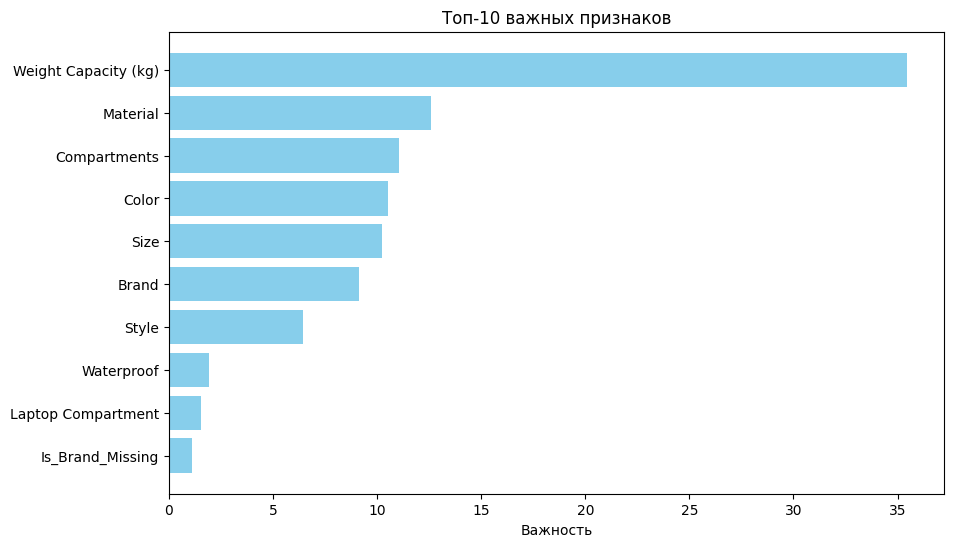

In [33]:
# Сортировка признаков по важности
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [X.columns[i] for i in sorted_idx]
sorted_importances = [feature_importances[i] for i in sorted_idx]

# График
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_importances[:10], color='skyblue')
plt.xlabel('Важность')
plt.title('Топ-10 важных признаков')
plt.gca().invert_yaxis()
plt.show()

### Linear

In [36]:
fill_brand_df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Is_Brand_Missing
id,,,,,,,,,,,
0,Jansport,Leather,Medium,0.538408,True,False,Tote,Black,-0.921466,112.15875,0
1,Jansport,Canvas,Small,1.576198,True,True,Messenger,Green,1.299086,68.88056,0
2,Under Armour,Leather,Small,-1.191240,True,False,Messenger,Red,-0.199023,39.17320,0
3,Nike,Nylon,Small,0.884338,True,False,Messenger,Green,-0.731166,80.60793,0
4,Adidas,Canvas,Medium,-1.537170,True,True,Messenger,Green,-0.040296,86.02312,0
...,...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,1.230268,False,False,Tote,Blue,-0.760800,129.99749,0
299996,Jansport,Leather,Large,0.192479,False,True,Tote,Blue,1.235147,19.85819,0
299997,Puma,Canvas,Large,1.230268,True,True,Backpack,Pink,-0.880330,111.41364,0


In [ ]:

fill_brand_cat_df = pd.get_dummies(
    fill_brand_df.drop("Is_Brand_Missing", axis=1),
    columns=[
        "Size",
        "Brand",
        "Material",
        "Laptop Compartment",
        "Waterproof",
    ],
)

le = LabelEncoder()
fill_brand_cat_df["Color"] = le.fit_transform(fill_brand_cat_df["Color"])
fill_brand_cat_df["Style"] = le.fit_transform(fill_brand_cat_df["Style"])

In [45]:
fill_brand_cat_df.head()

,Compartments,Style,Color,Weight Capacity (kg),Price,Size_Large,Size_Medium,Size_Small,Size_Unknown,Brand_Adidas,...,Brand_Unknown,Material_Canvas,Material_Leather,Material_Nylon,Material_Polyester,Material_Unknown,Laptop Compartment_False,Laptop Compartment_True,Waterproof_False,Waterproof_True
id,,,,,,,,,,,,,,,,,,,,,
0,0.538408,2,0,-0.921466,112.15875,False,True,False,False,False,...,False,False,True,False,False,False,False,True,True,False
1,1.576198,1,3,1.299086,68.88056,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,True
2,-1.191240,1,5,-0.199023,39.17320,False,False,True,False,False,...,False,False,True,False,False,False,False,True,True,False
3,0.884338,1,3,-0.731166,80.60793,False,False,True,False,False,...,False,False,False,True,False,False,False,True,True,False
4,-1.537170,1,3,-0.040296,86.02312,False,True,False,False,True,...,False,True,False,False,False,False,False,True,False,True


In [46]:
X_cat = fill_brand_cat_df.drop(target_col, axis=1)
y_cat = fill_brand_cat_df[target_col]

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.2, random_state=42
)

In [47]:
model_cat = LinearRegression()
model_cat.fit(X_train_cat, y_train_cat)

LinearRegression()

In [ ]:
y_pred = model_cat.predict(X_test_cat)

r2_score(y_test_cat, y_pred), mean_absolute_error(y_test_cat, y_pred)

(0.0010545245350920274, np.float64(38.92321468401629))

### RFR

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)
X_train_rfr, X_test_rfr, y_train_rfr, y_test_rfr = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, verbose=True)
rf_model.fit(X_train_rfr, y_train_rfr)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.6s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=True)

In [ ]:
y_pred = rf_model.predict(X_test_rfr)

r2_score(y_test_rfr, y_pred), mean_absolute_error(y_test_rfr, y_pred)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


(-0.05905843702750513, np.float64(40.07723690138407))

### XGBoost

In [79]:

# Обучение
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model.fit(X_train_cat, y_train_cat)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test_cat)

r2_score(y_test_cat, y_pred), mean_absolute_error(y_test_cat, y_pred)

(-0.008046215355256514, np.float64(39.10011468797938))